# Titanic!

## Preparation

### Imports

In [345]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier  
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

### Loading data

In [346]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Investigation

### NA's

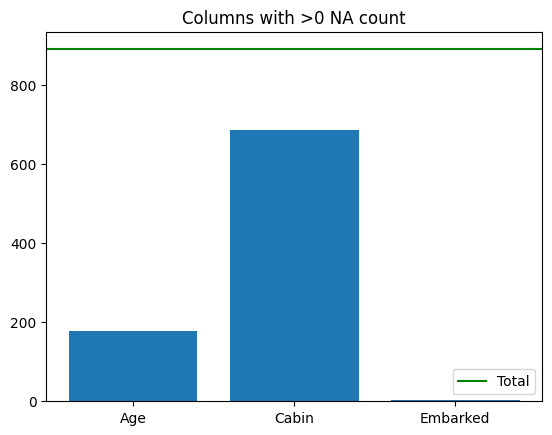

In [347]:
null_counts = [(column, null_count) for column in data.columns.values if (null_count := sum(data[column].isna())) > 0]
plt.bar(*list(zip(*null_counts)))

plt.axhline(len(data), color = 'green', label= "Total")
plt.title("Columns with >0 NA count")
plt.legend()

plt.show()

In [348]:
data = data.drop(columns='Cabin')
data = data.dropna(ignore_index=True)

### Categoricals

In [349]:
cat_cols = [ 'Pclass', 'Sex', 'Embarked']

In [350]:
def plot_categoricals(column): 
    categories = data[column].unique()

    survived_counts = []
    perished_counts = []
    survived_pcts = []
    perished_pcts = []
    for cat in categories:
        category_data = data[data[column] == cat]
        total = len(category_data)

        survived_count = len(category_data[category_data['Survived'] == 1])
        survived_counts.append(survived_count)

        perished_count = total - survived_count
        perished_counts.append(perished_count)

        survived_pcts.append(f'{survived_count / total:.1%}')
        perished_pcts.append(f'{perished_count / total:.1%}')

    fig, ax = plt.subplots()
    ax.bar(categories, survived_counts, color = "green", label = "Survived")
    ax.bar(categories, perished_counts, bottom=survived_counts, color = "red", label = "Perished")
    ax.set_title(f"Survivors by {column}")
    ax.bar_label(ax.containers[0], survived_pcts, label_type='center')
    ax.bar_label(ax.containers[1], perished_pcts, label_type='center')
    ax.legend()

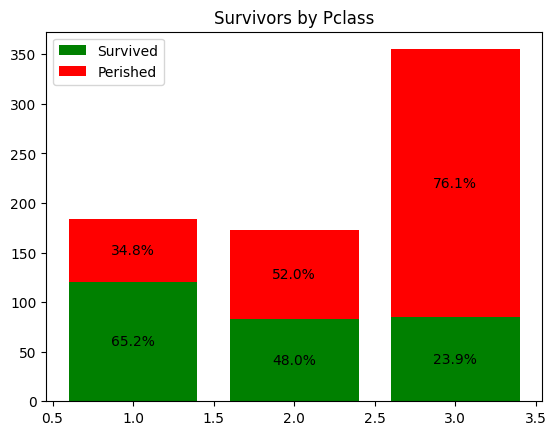

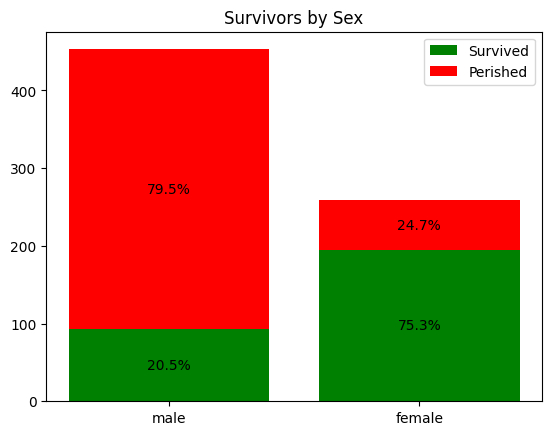

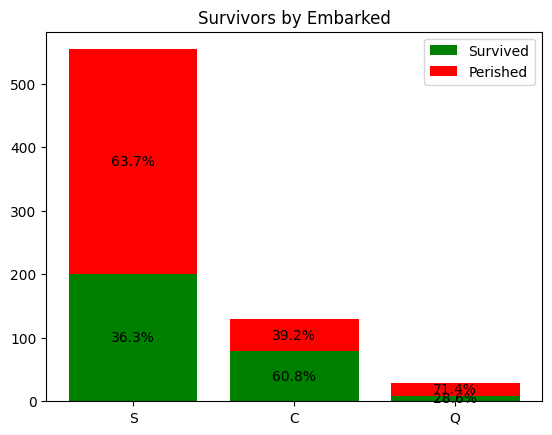

In [351]:
for col in cat_cols: plot_categoricals(col)

### Continuous

In [352]:
cont_cols = ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare']

In [353]:
data['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
707    39.0
708    27.0
709    19.0
710    26.0
711    32.0
Name: Age, Length: 712, dtype: float64

In [354]:
def plot_continuous(column):
    survived = data[column][data['Survived'] == 1]
    perished = data[column][data['Survived'] == 0]
    plt.hist([survived, perished], 10, color=['green', 'red'], label=['Survived', 'Perished'])
    plt.title(f"Survivors by {column}")
    plt.legend()
    plt.show()

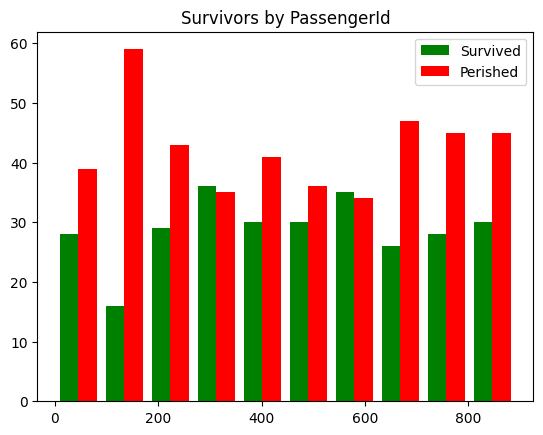

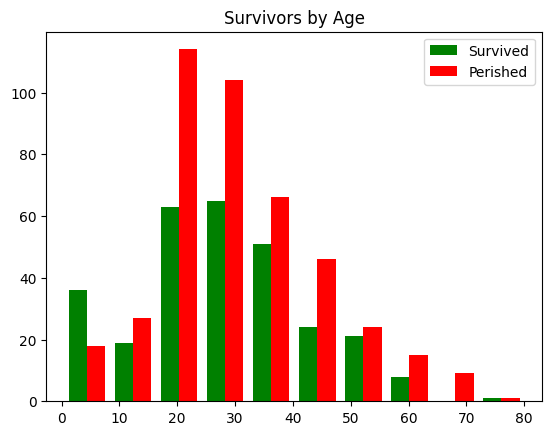

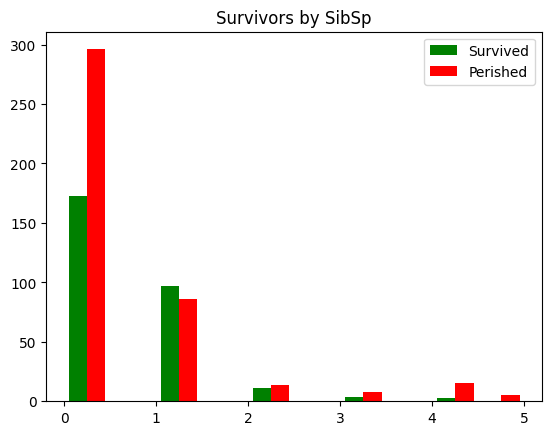

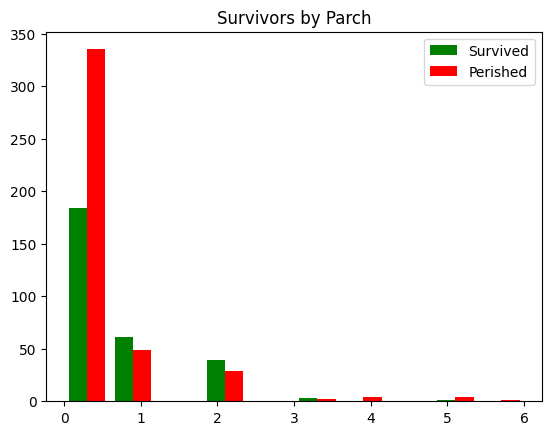

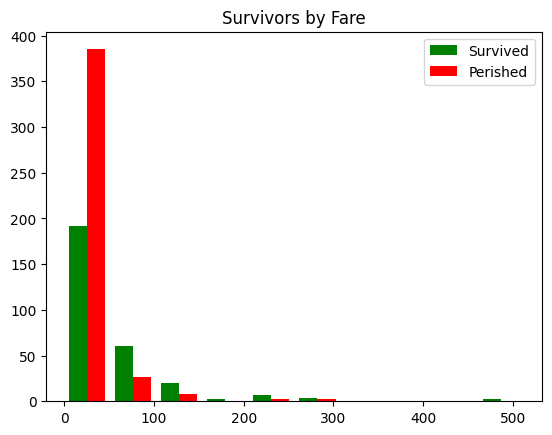

In [355]:
for col in cont_cols: plot_continuous(col)

## Models

In [356]:
# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run 
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[12, 6])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

In [357]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [358]:
data = data.drop(columns=['PassengerId', 'Name', 'Ticket'])

translator_sex = {
    'male': 0,
    'female': 1
}
data['Sex'] = data['Sex'].map(lambda x: translator_sex[x])

translator_embarked = {
    'C': 0,
    'Q': 1,
    'S': 2,
}
data['Embarked'] = data['Embarked'].map(lambda x: translator_embarked[x])


one_hot_embarked = np.eye(3)[np.array(data['Embarked'])]
embarked_df = pd.DataFrame(one_hot_embarked, columns=translator_embarked.keys())
data.join(embarked_df)



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,C,Q,S
0,0,3,0,22.0,1,0,7.2500,2,0.0,0.0,1.0
1,1,1,1,38.0,1,0,71.2833,0,1.0,0.0,0.0
2,1,3,1,26.0,0,0,7.9250,2,0.0,0.0,1.0
3,1,1,1,35.0,1,0,53.1000,2,0.0,0.0,1.0
4,0,3,0,35.0,0,0,8.0500,2,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
707,0,3,1,39.0,0,5,29.1250,1,0.0,1.0,0.0
708,0,2,0,27.0,0,0,13.0000,2,0.0,0.0,1.0
709,1,1,1,19.0,0,0,30.0000,2,0.0,0.0,1.0
710,1,1,0,26.0,0,0,30.0000,0,1.0,0.0,0.0


In [361]:
y = 'Survived'
# x = ['Pclass', 'Age', 'SibSp','Parch', 'Fare']
x = ['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked']

for col in cat_cols: data[col] = pd.Categorical(data[col])

y_data = data[y]
x_data = data[x]

x_train, x_remains, y_train, y_remains = train_test_split(x_data, y_data, test_size= 0.3, random_state= 1)
x_val, x_test, y_val, y_test = train_test_split(x_remains, y_remains, test_size= 0.5, random_state= 1)

              precision    recall  f1-score   support

           0       0.81      0.84      0.83        68
           1       0.70      0.67      0.68        39

    accuracy                           0.78       107
   macro avg       0.76      0.75      0.76       107
weighted avg       0.77      0.78      0.77       107



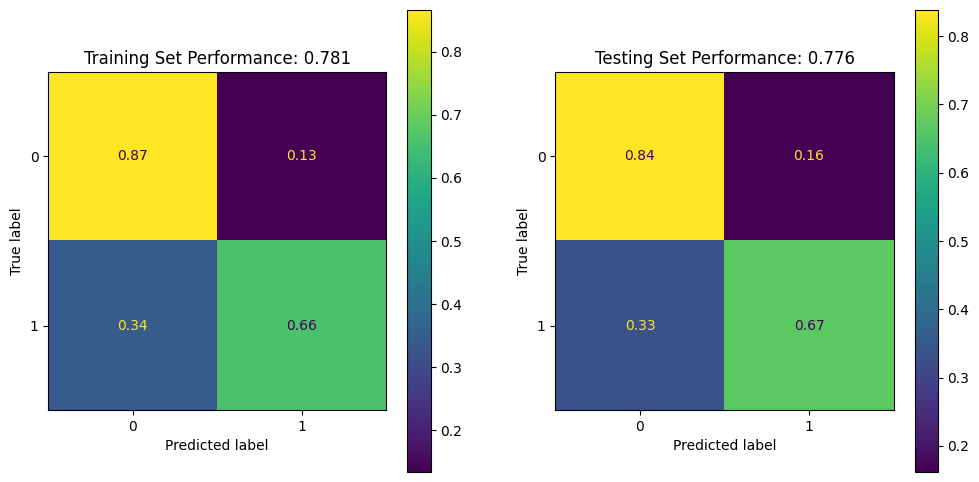

In [362]:
svm_lin = SVC(C=1.0, kernel='linear')
svm_lin.fit(x_train, y_train)
eval_model(svm_lin, x_train, y_train, x_test, y_test)